In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.transforms import Affine2D
from typing import List, Optional, Tuple, Dict
import dataclasses
import time as ti
from scipy.stats import wasserstein_distance
import pygad


In [4]:
@dataclasses.dataclass
class CarState:
    x: float  # x position
    y: float  # y position
    theta: float  # current heading angle in radians --- do we need this?
    steering_angle: float = 0.0  # current steering angle

@dataclasses.dataclass
class TrackConfig:
    bounds: Tuple[Tuple[float, float], Tuple[float, float]]
    obstacles: List[Tuple[float, float, float]]
    track_width: float  # Added track width parameter
    inner_boundary: np.ndarray  # Array of (x, y) points for inner boundary
    outer_boundary: np.ndarray  # Array of (x, y) points for outer boundary

def generate_track_boundaries(centerline_points: List[Tuple[float, float]], track_width: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate inner and outer track boundaries from centerline points with consistent width."""
    points = np.array(centerline_points)
    inner_boundary = []
    outer_boundary = []
    
    # Ensure the track is closed by appending the first point if needed
    if not np.array_equal(points[0], points[-1]):
        points = np.append(points, [points[0]], axis=0)

    for i in range(len(points) - 1):
        # Get current point and next point
        current = points[i]
        next_point = points[i + 1]
        
        # Get previous point (wrap around to last point if at start)
        prev_point = points[i - 1] if i > 0 else points[-2]
        
        # Calculate direction vectors
        dir_to_next = next_point - current
        dir_to_prev = current - prev_point
        
        # Normalize direction vectors
        dir_to_next = dir_to_next / np.linalg.norm(dir_to_next)
        dir_to_prev = dir_to_prev / np.linalg.norm(dir_to_prev)
        
        # Calculate average direction for smooth corners
        avg_direction = dir_to_next + dir_to_prev
        avg_direction = avg_direction / np.linalg.norm(avg_direction)
        
        # Calculate normal vector (rotate average direction 90 degrees)
        normal = np.array([-avg_direction[1], avg_direction[0]])
        
        # Generate inner and outer points
        inner_point = current - normal * (track_width / 2)
        outer_point = current + normal * (track_width / 2)
        
        inner_boundary.append(inner_point)
        outer_boundary.append(outer_point)
    
    # Add closing points
    inner_boundary.append(inner_boundary[0])
    outer_boundary.append(outer_boundary[0])
    
    return np.array(inner_boundary), np.array(outer_boundary)

@dataclasses.dataclass
class LIDARReading:
    distances: np.ndarray  # Array of distances for each beam
    noisy_distances: np.ndarray
    angles: np.ndarray    # Array of angles for each beam
    hit_points: np.ndarray  # Array of (x,y) coordinates where each beam hits
    collisions: bool

class LIDARSimulator:
    """
    LIDAR simulation component that performs ray casting to detect obstacles and track boundaries.
    Simulates a LIDAR sensor mounted on the front of the car.
    """
    def __init__(self, 
                 num_beams: int = 180,
                 max_range: float = 10.0,
                 angle_span: float = np.pi,
                 car_length: float = 5.0,
                 car_width: float = 2.5,
                 mount_offset: float = 0., # Offset from car front center
                 ray_std: float = 0.01, 
                 collision_threshold: float = 0.1):  
        """
        Initialize the LIDAR simulator.
        
        Args:
            num_beams: Number of LIDAR beams
            max_range: Maximum detection range
            angle_span: Angular span of the sensor in radians
            car_length: Length of the car for mounting position
            car_width: Width of the car for mounting position
            mount_offset: Offset from car center (positive is right, negative is left)
        """
        self.num_beams = num_beams
        self.max_range = max_range
        self.angle_span = angle_span
        self.car_length = car_length
        self.car_width = car_width
        self.mount_offset = mount_offset
        self.ray_std = ray_std
        self.collision_threshold = collision_threshold
        
        # Pre-calculate beam angles for efficiency
        self.beam_angles = np.linspace(-angle_span/2, angle_span/2, num_beams)
    
    def get_sensor_position(self, car_state: 'CarState') -> np.ndarray:
        """Calculate LIDAR sensor position based on car state."""
        # Calculate offset from car's rear axle to sensor mounting point
        x_offset = self.car_length * np.cos(car_state.theta)
        y_offset = self.car_length * np.sin(car_state.theta)
        
        # Add lateral offset if sensor is not mounted at center
        if self.mount_offset != 0:
            lateral_x = -self.mount_offset * np.sin(car_state.theta)
            lateral_y = self.mount_offset * np.cos(car_state.theta)
            x_offset += lateral_x
            y_offset += lateral_y
            
        return np.array([
            car_state.x + x_offset,
            car_state.y + y_offset
        ])

    def cast_ray(self, 
                 origin: np.ndarray,
                 angle: float,
                 track_config: 'TrackConfig') -> Tuple[float, np.ndarray]:
        """
        Cast a single ray and find the closest intersection point.
        
        Returns:
            Tuple of (distance, hit_point)
        """
        # Calculate ray endpoint at max range
        direction = np.array([np.cos(angle), np.sin(angle)])
        end_point = origin + direction * self.max_range
        
        closest_dist = self.max_range
        closest_point = end_point.copy()
        
        # Check track boundary intersections
        for boundary in [track_config.inner_boundary, track_config.outer_boundary]:
            for i in range(len(boundary) - 1):
                intersection = self._line_intersection(
                    origin, end_point,
                    boundary[i], boundary[i + 1]
                )
                if intersection is not None:
                    dist = np.linalg.norm(intersection - origin)
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_point = intersection

        # Check obstacle intersections
        for obstacle in track_config.obstacles:
            intersection = self._circle_intersection(
                origin, end_point, 
                np.array([obstacle[0], obstacle[1]]), obstacle[2]
            )
            if intersection is not None:
                dist = np.linalg.norm(intersection - origin)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_point = intersection
                    
        return closest_dist + np.random.normal(0, self.ray_std), closest_point

    def get_readings(self, car_state: 'CarState', track_config: 'TrackConfig', collision_threshold) -> LIDARReading:
        """Get LIDAR readings for the current car state and track configuration."""
        sensor_pos = self.get_sensor_position(car_state)
        
        # Initialize arrays for storing results
        distances = np.zeros(self.num_beams)
        hit_points = np.zeros((self.num_beams, 2))
        
        # Calculate absolute angles by adding car's heading to relative angles
        absolute_angles = self.beam_angles + car_state.theta
        
        # Cast rays for each beam
        for i, angle in enumerate(absolute_angles):
            distances[i], hit_points[i] = self.cast_ray(sensor_pos, angle, track_config)

        noisy_distances = distances + np.random.normal(0, self.ray_std)

        collision_threshold = self.collision_threshold
        collision_detected = np.any(distances < collision_threshold)        

        return LIDARReading(
            distances=distances,
            noisy_distances=noisy_distances, 
            angles=self.beam_angles,  # Return relative angles for easier processing
            hit_points=hit_points, 
            collisions = collision_detected
        )

    def _line_intersection(self,
                          ray_start: np.ndarray,
                          ray_end: np.ndarray,
                          line_start: np.ndarray,
                          line_end: np.ndarray) -> Optional[np.ndarray]:
        """Calculate intersection between ray and line segment using vector cross product."""
        p0, p1 = ray_start, ray_end
        p2, p3 = line_start, line_end
        
        s1 = p1 - p0
        s2 = p3 - p2
        
        det = np.cross(s1, s2)
        
        if abs(det) < 1e-10:  # Lines are parallel
            return None
            
        s = np.cross(p2 - p0, s2) / det
        t = np.cross(p2 - p0, s1) / det
        
        if 0 <= s <= 1 and 0 <= t <= 1:
            return p0 + s * s1
        
        return None

    def _circle_intersection(self,
                           ray_start: np.ndarray,
                           ray_end: np.ndarray,
                           circle_center: np.ndarray,
                           circle_radius: float) -> Optional[np.ndarray]:
        """Calculate intersection between ray and circle using quadratic equation."""
        direction = ray_end - ray_start
        direction = direction / np.linalg.norm(direction)
        
        oc = ray_start - circle_center
        
        a = 1  # Normalized direction vector
        b = 2 * np.dot(direction, oc)
        c = np.dot(oc, oc) - circle_radius * circle_radius
        
        discriminant = b * b - 4 * a * c
        
        if discriminant < 0:
            return None
            
        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        
        # Get smallest positive intersection
        t = float('inf')
        if t1 >= 0:
            t = min(t, t1)
        if t2 >= 0:
            t = min(t, t2)
            
        if t == float('inf'):
            return None
            
        return ray_start + direction * t

class CarController:
    def __init__(self, gap_threshold: float = 3.0, num_beams: int = 180, angle_span: float = np.pi, ratio: float = 0.95):
        self.gap_threshold = gap_threshold
        self.num_beams = num_beams
        self.angle_span = angle_span  # This should match LIDAR's angle_span
        self.ratio = ratio

    def get_steering_angle(self, lidar_data: np.ndarray) -> float:
        # print(f"lidar_data: {lidar_data}")
        """Steer the car towards the maximum gap in the LIDAR data"""
        # Create angle array matching LIDAR's angle distribution
        angle_array = np.linspace(-self.angle_span/2, self.angle_span/2, self.num_beams)
        
        # Add shape check with more informative error message
        if lidar_data.shape[0] != angle_array.shape[0]:
            raise ValueError(f"LIDAR data shape {lidar_data.shape} must match angle array shape {angle_array.shape}")

        # Split LIDAR data into segments based on gap threshold
        gaps = lidar_data > self.gap_threshold
        gap_indices = np.where(gaps)[0]
        
        if len(gap_indices) == 0:
            # If no gaps found, return neutral steering
            return 0.0
        
        # Find the longest continuous gap
        gap_diff = np.diff(gap_indices)
        gap_starts = np.concatenate([[0], np.where(gap_diff > 1)[0] + 1])
        gap_ends = np.concatenate([np.where(gap_diff > 1)[0], [len(gap_indices) - 1]])
        
        gap_lengths = gap_ends - gap_starts + 1
        longest_gap_idx = np.argmax(gap_lengths)
        start_idx = gap_indices[gap_starts[longest_gap_idx]]
        end_idx = gap_indices[gap_ends[longest_gap_idx]]
        
        # Find the furthest point in the gap
        best_idx = np.argmax(lidar_data[start_idx:end_idx+1]) + start_idx

        # Calculate center of the longest gap
        center_idx = (start_idx + end_idx) // 2

        # Use a weighted average of the center and best points
        steering_angle = angle_array[int(self.ratio*center_idx + (1-self.ratio)*best_idx)]
        return steering_angle

class CarKinematics:
    def __init__(self, car_length: float = 0.4, velocity: float = 1.0, dt: float = 0.05, x_std: float = 0.01, y_std: float = 0.01, theta_std: float = 0.01):
        self.car_length = car_length
        self.velocity = velocity
        self.dt = dt
        self.x_std = x_std
        self.y_std = y_std
        self.theta_std = theta_std
        self.state_history = []

    def update_state(self, current_state: CarState, steering_angle: float) -> CarState:
        """Update the car state using the kinematic model"""
        # Store old state in state history
        self.state_history.append(current_state)

        # Avoid instability for very small steering angles
        if abs(steering_angle) < 1e-2:
            steering_angle = 0.0

        # Update state with Gaussian noise
        x, y, theta = current_state.x, current_state.y, current_state.theta
        new_x = x + self.velocity * np.cos(theta) * self.dt + np.random.normal(0, self.x_std)
        new_y = y + self.velocity * np.sin(theta) * self.dt + np.random.normal(0, self.y_std)
        new_theta = theta + self.velocity / self.car_length * np.tan(steering_angle) * self.dt + np.random.normal(0, self.theta_std)
        return CarState(new_x, new_y, new_theta, steering_angle)

class TrackVisualizer:
    def __init__(self, track_config: TrackConfig):
        self.track_config = track_config
        self.setup_visualization()

    def setup_visualization(self):
        """Initialize the visualization"""
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        bounds = self.track_config.bounds
        self.ax.set_xlim(bounds[0])
        self.ax.set_ylim(bounds[1])
        self.ax.set_aspect('equal')

        # Create car rectangle
        self.car_width = 0.4
        self.car_height = 0.2
        self.car = Rectangle((-self.car_width/2, -self.car_height/2),
                           self.car_width, self.car_height,
                           facecolor='red', edgecolor='darkred')
        self.ax.add_patch(self.car)

        # Draw track and obstacles
        self.draw_track()
        self.draw_obstacles()

    def draw_track(self):
        """Draw the track with filled area between boundaries"""
        # Draw outer boundary
        outer_track = Polygon(self.track_config.outer_boundary,
                            facecolor='lightgray',
                            edgecolor='black',
                            fill=True)
        self.ax.add_patch(outer_track)
        
        # Draw inner boundary (the hole)
        inner_track = Polygon(self.track_config.inner_boundary,
                            facecolor='white',
                            edgecolor='black',
                            fill=True)
        self.ax.add_patch(inner_track)

    def draw_obstacles(self):
        """Draw the obstacles"""
        for x, y, radius in self.track_config.obstacles:
            obstacle = Circle((x, y), radius, facecolor='gray', edgecolor='black')
            self.ax.add_patch(obstacle)

    def update_visualization(self, car_state: CarState):
        """Update the visualization for the current state"""
        # Update car position and orientation
        transform = Affine2D() \
            .rotate(car_state.theta) \
            .translate(car_state.x, car_state.y)

        # Set the car's transform to the calculated affine transform
        self.car.set_transform(transform + self.ax.transData)

        # Redraw the plot
        # self.ax.draw_artist(self.car)
        # self.ax.figure.canvas.blit(self.ax.bbox)
        # self.ax.figure.canvas.flush_events()


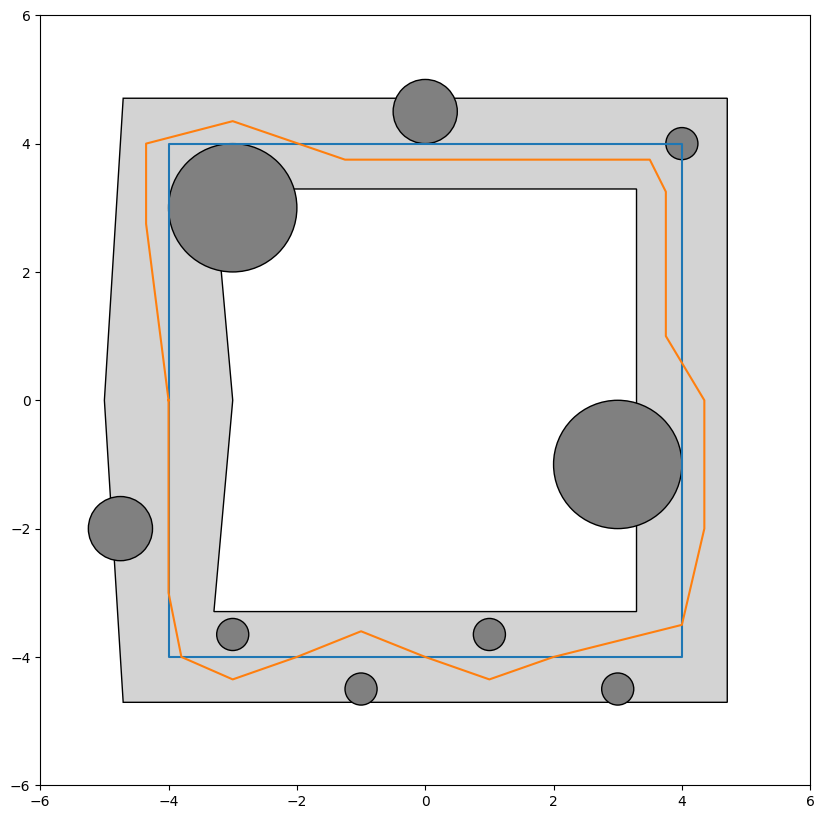

In [57]:
# Define centerline points for a larger, centered oval track 
centerline_points = [
    (-4, 0),
    (-4, 4), 
    (4, 4), 
    (4, -4),
    (-4, -4), 
    (-4, 0)
]

track_width = 2.0  # Increased track width for better visibility

# Generate track boundaries
inner_boundary, outer_boundary = generate_track_boundaries(centerline_points, track_width)

# Create track configuration with better distributed obstacles
track_config = TrackConfig(
    bounds=((-6, 6), (-6, 6)),
    obstacles = [
        (-3, 3, 1), 
        (0, 4.5, -0.5), 
        (4, 4, 0.25), 
        (3, -1, 1), 
        (3, -4.5, 0.25),
        (1, -3.65, 0.25), 
        (-1, -4.5, 0.25), 
        (-3, -3.65, 0.25), 
        (-4.75, -2, 0.5)
    ],
    track_width=track_width,
    inner_boundary=inner_boundary,
    outer_boundary=outer_boundary
)

centerline_points = np.array(centerline_points)
xcoords = centerline_points[:,0]
ycoords = centerline_points[:,1]

# haha bruteforced an optimal path :clown:
optimal_path = [
    (-4, 0),
    (-4.35, 2.75),
    (-4.35, 4), 
    (-3, 4.35),
    (-1.25, 3.75),
    (3.5, 3.75), 
    (3.75, 3.25),
    (3.75, 1),
    (4.35, 0),
    (4.35, -2),
    (4, -3.5),
    (2, -4),
    (1, -4.35),
    (0, -4),
    (-1, -3.6),
    (-2, -4),
    (-3, -4.35),
    (-3.8, -4), 
    (-4, -3),
    (-4, 0)
]
optimal_path = np.array(optimal_path)
x_opt = optimal_path[:, 0]
y_opt = optimal_path[:, 1]

visualizer = TrackVisualizer(track_config)
plt.plot(xcoords, ycoords)
plt.plot(x_opt, y_opt)

In [52]:
# Initialize components with tuned parameters
car_length = 0.1
collisions = 0

######## PARAMETERS TO CHANGE ############
noise = 0.001
ray_noise = 0.03
angle_span = np.pi * 2/3    # 120 degree field of view
num_beams = 120
gap_threshold = 0.25
collision_threshold = 0
##########################################

lidar = LIDARSimulator(
    num_beams=num_beams,
    angle_span=angle_span,  
    max_range=5.0,
    car_length=car_length,
    car_width=0.1, 
    ray_std = ray_noise, 
    collision_threshold=collision_threshold
)
controller = CarController(
    gap_threshold=gap_threshold,
    num_beams=num_beams,
    angle_span=angle_span  # Match LIDAR's angle span
)
kinematics = CarKinematics(
    car_length=car_length,
    velocity=2,  # Reduced velocity for better control
    dt=0.05,
    x_std=noise,   # Reduced noise for smoother motion
    y_std=noise,
    theta_std=noise
)

# Initial car state - start at the beginning of the track
initial_heading = np.arctan2(
    centerline_points[1][1] - centerline_points[0][1],
    centerline_points[1][0] - centerline_points[0][0]
)
car_state = CarState(centerline_points[0][0], centerline_points[0][1], initial_heading)

In [53]:
end = 23       # arbitrary time
length = np.arange(0, end, kinematics.dt)

trajectory = [(car_state.x, car_state.y)]
lidar_distances = []
noisy_distances = []

start_time = ti.time()

    
for i in range(len(length)):
    # Get LIDAR readings
    lidar_reading = lidar.get_readings(car_state, track_config, collision_threshold)
    if lidar_reading.collisions:
        collisions += 1
    lidar_distances.append(lidar_reading.distances)
    noisy_distances.append(lidar_reading.noisy_distances)

    # Get steering decision
    steering_angle = controller.get_steering_angle(lidar_reading.distances)

    # Update car state
    car_state = kinematics.update_state(car_state, steering_angle)
    trajectory.append((car_state.x, car_state.y))

end_time = ti.time()
sim_time = end_time - start_time


In [ ]:
trajectory = np.array(trajectory)

visualizer = TrackVisualizer(track_config)
plt.plot(xcoords, ycoords)
plt.plot(x_opt, y_opt)
plt.plot(trajectory[:,0], trajectory[:, 1])

## GA starts here 

In [ ]:
# simulation

def simulation(angle, nbeams):
    # Initialize components with tuned parameters
    car_length = 0.1
    collisions = 0

    ######## PARAMETERS TO CHANGE ############
    noise = 0.001
    ray_noise = 0.03
    angle_span = angle    # np.pi * 2/3 = 120 degree field of view
    num_beams = nbeams
    gap_threshold = 0.25
    collision_threshold = 0
    ##########################################

    lidar = LIDARSimulator(
        num_beams=num_beams,
        angle_span=angle_span,  
        max_range=5.0,
        car_length=car_length,
        car_width=0.1, 
        ray_std = ray_noise, 
        collision_threshold=collision_threshold
    )
    controller = CarController(
        gap_threshold=gap_threshold,
        num_beams=num_beams,
        angle_span=angle_span  # Match LIDAR's angle span
    )
    kinematics = CarKinematics(
        car_length=car_length,
        velocity=2,  # Reduced velocity for better control
        dt=0.05,
        x_std=noise,   # Reduced noise for smoother motion
        y_std=noise,
        theta_std=noise
    )

    # Initial car state - start at the beginning of the track
    initial_heading = np.arctan2(
        centerline_points[1][1] - centerline_points[0][1],
        centerline_points[1][0] - centerline_points[0][0]
    )
    car_state = CarState(centerline_points[0][0], centerline_points[0][1], initial_heading)

    end = 23       # arbitrary time
    length = np.arange(0, end, kinematics.dt)

    trajectory = [(car_state.x, car_state.y)]
    lidar_distances = []
    noisy_distances = []

        
    for i in range(len(length)):
        # Get LIDAR readings
        lidar_reading = lidar.get_readings(car_state, track_config, collision_threshold)
        if lidar_reading.collisions:
            collisions += 1
        lidar_distances.append(lidar_reading.distances)
        noisy_distances.append(lidar_reading.noisy_distances)

        # Get steering decision
        steering_angle = controller.get_steering_angle(lidar_reading.distances)

        # Update car state
        car_state = kinematics.update_state(car_state, steering_angle)
        trajectory.append((car_state.x, car_state.y))

    return np.array(trajectory)


In [65]:
# Optimization using GA (pygad)

# fitness function, goal is to minimize emd
def fitness_func(ga_instance, solution, solution_idx):
    angle_span = solution[0]
    num_beams = int(solution[1])
    trajectory = simulation(angle_span, num_beams)
    emd = wasserstein_distance(trajectory.flatten(), optimal_path.flatten())
    fitness = 1 / emd       # GA aims to maximize fitness

    return fitness

function_inputs = [np.pi * 2/3, 120]

fitness_function = fitness_func

### GA parameters ##################
num_generations = 60
num_parents_mating = 5

sol_per_pop = 10
num_genes = len(function_inputs)

init_range_low = [10/180 * np.pi, 10]  # Lower bound for angle_span (10 deg) and num_beams (10 beams)
init_range_high = [np.pi, 360]  # Upper bound for angle_span (180deg) and num_beams (360 beams)

parent_selection_type = "sss"
keep_parents = 5

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5
#####################################

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

In [70]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

Parameters of the best solution : [ 2.48234859 42.41895128]
Fitness value of the best solution = 3.9064923532067857
Index of the best solution : 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


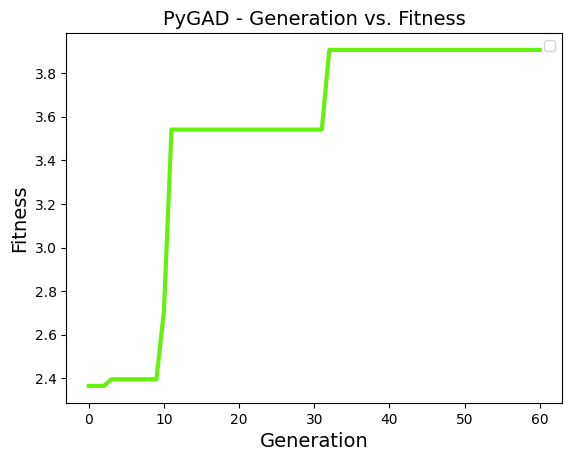

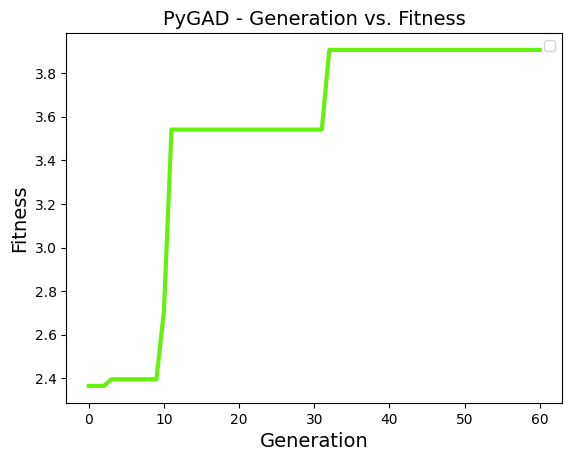

In [71]:
ga_instance.plot_fitness()

In [68]:
best_trajectory = simulation(int(solution[0]), int(solution[1]))

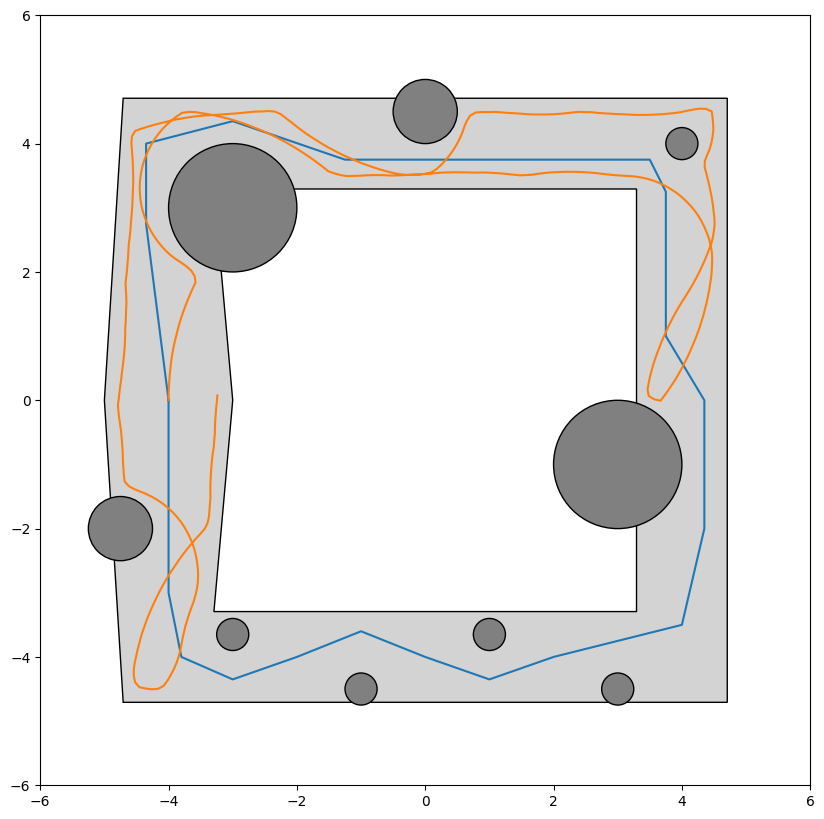

In [69]:
visualizer = TrackVisualizer(track_config)
plt.plot(x_opt, y_opt)
plt.plot(best_trajectory[:,0], best_trajectory[:, 1])